# Activation checkpointing

Notebook exploring how much memory activation checkpointing saves under different setups, e.g. different model sizes, different sequence lengths, checkpointing different layers, etc.

In [1]:
from dataclasses import dataclass
from collections import OrderedDict
import itertools

from rich.console import Console
from rich.table import Table
import seaborn as sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


@dataclass
class ModelConfig:
    n_ctx: int = 1024
    n_layer: int = 12
    n_head: int = 12
    d_model: int = 768
    d_mlp: int = 4 * 768
    vocab_size: int = 50257
    ln_bias: bool = False
    mlp_bias: bool = False
    share_embd_params: bool = True


MODEL_CONFIG_ARGS = {
    # 14M params
    "gpt2-tiny": ModelConfig(
        n_ctx=128,
        n_layer=2,
        n_head=4,
        d_model=256,
        d_mlp=4 * 256,
        vocab_size=50257,
        ln_bias=True,
        mlp_bias=True,
        share_embd_params=True,
    ),
    # 124M params
    "gpt2": ModelConfig(
        n_ctx=1024,
        n_layer=12,
        n_head=12,
        d_model=768,
        d_mlp=4 * 768,
        vocab_size=50257,
        ln_bias=True,
        mlp_bias=True,
        share_embd_params=True,
    ),
    # 350M params
    "gpt2-medium": ModelConfig(
        n_ctx=1024,
        n_layer=24,
        n_head=16,
        d_model=1024,
        d_mlp=4 * 1024,
        vocab_size=50257,
        ln_bias=True,
        mlp_bias=True,
        share_embd_params=True,
    ),
    # 774M params
    "gpt2-large": ModelConfig(
        n_ctx=1024,
        n_layer=36,
        n_head=20,
        d_model=1280,
        d_mlp=4 * 1280,
        vocab_size=50257,
        ln_bias=True,
        mlp_bias=True,
        share_embd_params=True,
    ),
    # 1558M params
    "gpt2-xl": ModelConfig(
        n_ctx=1024,
        n_layer=48,
        n_head=25,
        d_model=1600,
        d_mlp=4 * 1600,
        vocab_size=50257,
        ln_bias=True,
        mlp_bias=True,
        share_embd_params=True,
    ),
}


def load_config(name: str) -> ModelConfig:
    assert name in MODEL_CONFIG_ARGS
    return MODEL_CONFIG_ARGS[name]


# TODO Change this as desired
model_cfg = load_config("gpt2")

In [2]:
def get_params(cfg: ModelConfig, checkpoint_layers: set[str] | None = None):
    """Estimates the number of parameters in the model."""
    out = OrderedDict()
    if checkpoint_layers is None:
        checkpoint_layers = set()

    # token and position embeddings
    if "embedding" not in checkpoint_layers:
        out["embedding/position"] = cfg.n_ctx * cfg.d_model
        out["embedding/token"] = cfg.vocab_size * cfg.d_model
        out["embedding"] = out["embedding/position"] + out["embedding/token"]
    else:
        out["embedding"] = 0

    # attention blocks
    if "attention" not in checkpoint_layers:
        out["attention/ln"] = cfg.d_model + int(cfg.ln_bias) * cfg.d_model
        out["attention/kqv"] = cfg.d_model * 3 * cfg.d_model
        out["attention/proj"] = cfg.d_model**2
        out["attention"] = (
            out["attention/ln"] + out["attention/kqv"] + out["attention/proj"]
        )
    else:
        out["attention"] = 0
    out["attention_all"] = cfg.n_layer * out["attention"]

    # MLP blocks
    if "mlp" not in checkpoint_layers:
        out["mlp/ln"] = cfg.d_model + int(cfg.ln_bias) * cfg.d_model
        out["mlp/ffw"] = cfg.d_model * cfg.d_mlp + int(cfg.ln_bias) * cfg.d_mlp
        out["mlp/proj"] = cfg.d_mlp * cfg.d_model + int(cfg.ln_bias) * cfg.d_model
        out["mlp"] = out["mlp/ln"] + out["mlp/ffw"] + out["mlp/proj"]
    else:
        out["mlp"] = 0
    out["mlp_all"] = cfg.n_layer * out["mlp"]

    # the transformer and the rest of it
    out["block"] = out["attention"] + out["mlp"]
    out["transformer"] = cfg.n_layer * out["block"]
    out["ln_f"] = cfg.d_model + int(cfg.ln_bias) * cfg.d_model  # final layernorm
    if cfg.share_embd_params:
        # 0 because of parameter sharing. This layer uses the weights from the embedding layer
        out["out_embedding"] = 0
    else:
        out["out_embedding"] = cfg.d_model * cfg.vocab_size

    # total
    out["total"] = (
        out["embedding"] + out["transformer"] + out["ln_f"] + out["out_embedding"]
    )

    return out

In [3]:
possible_checkpoints = [
    "embedding",
    "attention_all",
    "mlp_all",
]

base_params = get_params(model_cfg)["total"]
n_ctx = model_cfg.n_ctx

params_by_checkpoint_policy = {
    "None": base_params,
}
# iterate through all possible permutation of checkpointing,
# e.g. [["embedding"], ["embedding", "attention"], ["embedding", "attention", "mlp"]]
for checkpoint_combo in itertools.chain.from_iterable(
    itertools.combinations(possible_checkpoints, i)
    for i in range(1, len(possible_checkpoints) + 1)
):
    params = get_params(model_cfg, set(checkpoint_combo))["total"]
    params_by_checkpoint_policy[str(checkpoint_combo)] = params


total_base_params = base_params + (base_params * n_ctx * 2)
base_memory_gb = total_base_params / 1024**3

table_headers = [
    "Checkpoint Policy",
    "Forward Params Stored",
    "Total Params Stored",
    "Total Memory (GB)",
    "Params Savings",
    "Memory Savings (%)",
]
table_rows = []
for checkpoint_policy, forward_params in params_by_checkpoint_policy.items():
    # Assume we are using 16-bit precision (i.e. 2 bytes per parameter)
    # Checkpointing still stores the full model + backwards activations, just
    # not some forward activations.
    n_forward_activations = forward_params * n_ctx
    n_backward_activations = base_params * n_ctx
    total_params_stored = base_params + ((base_params + forward_params) * n_ctx * 2)
    total_memory_bytes = total_params_stored * 2
    total_memory_gb = total_memory_bytes / (1024**3)
    params_savings = (total_base_params - forward_params) / total_base_params * 100
    memory_savings = (total_memory_gb - base_memory_gb) / total_memory_gb * 100
    table_rows.append(
        [
            checkpoint_policy,
            str(forward_params),
            str(total_params_stored),
            f"{total_memory_gb:.2f}",
            f"{params_savings:.2f}%",
            f"{memory_savings:.2f}%",
        ]
    )

table = Table(title="Activation Checkpointing")
for header in table_headers:
    table.add_column(header)
for row in table_rows:
    table.add_row(*row)

console = Console()
console.print(table)


                                             Activation Checkpointing                                              
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint       ┃ Forward Params    ┃ Total Params     ┃                   ┃                ┃ Memory Savings   ┃
┃ Policy           ┃ Stored            ┃ Stored           ┃ Total Memory (GB) ┃ Params Savings ┃ (%)              ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ None             │ 124402944         │ 509678861568     │ 949.35            │ 99.95%         │ 74.99%           │
│ ('embedding',)   │ 85019136          │ 429020822784     │ 799.11            │ 99.97%         │ 70.29%           │
│ ('attention_all… │ 124402944         │ 509678861568     │ 949.35            │ 99.95%         │ 74.99%           │
│ ('mlp_all',)     │ 124402944         │ 509678861568     │ 949.35            │ 99.95%         │ 74.99%           │
│ ('embedding',    │ 85019136          │ 429020822784     │ 799.11            │ 99.97%         │ 70.29%           │
│ 'attention_all') │                   │                  │                   │                │                  │
│ ('embedding',    │ 85019136          │ 429020822784     │ 799.11            │ 99.97%         │ 70.29%           │
│ 'mlp_all')       │                   │                  │                   │                │                  │
│ ('attention_all… │ 124402944         │ 509678861568     │ 949.35            │ 99.95%         │ 74.99%           │
│ 'mlp_all')       │                   │                  │                   │                │                  │
│ ('embedding',    │ 85019136          │ 429020822784     │ 799.11            │ 99.97%         │ 70.29%           │
│ 'attention_all', │                   │                  │                   │                │                  │
│ 'mlp_all')       │                   │                  │                   │                │                  │
└──────────────────┴───────────────────┴──────────────────┴───────────────────┴────────────────┴──────────────────┘

<Axes: xlabel='model_size', ylabel='memory_savings'>

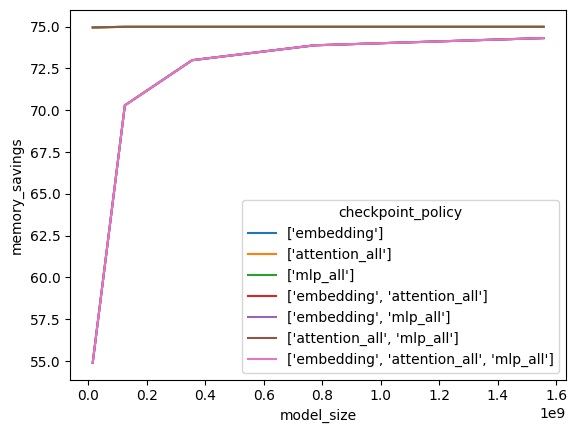

In [4]:
# Look at memory savings (y) by model size (x) by checkpoint policy (z)
possible_checkpoints = ["embedding", "attention_all", "mlp_all"]

all_model_params = [
    (name, cfg, int(get_params(cfg)["total"]))
    for name, cfg in MODEL_CONFIG_ARGS.items()
]
sorted(all_model_params, key=lambda z: z[2])

all_checkpoint_policies = list(
    itertools.chain.from_iterable(
        itertools.combinations(possible_checkpoints, i)
        for i in range(1, len(possible_checkpoints) + 1)
    )
)

# Create lists to store the data
data = []
for checkpoint_policy in all_checkpoint_policies:
    checkpoint_name = str(
        list(checkpoint_policy)
    )  # Convert tuple to string for display
    for model_name, model_cfg, base_params in all_model_params:
        checkpoint_policy_params = get_params(model_cfg, set(checkpoint_policy))[
            "total"
        ]
        n_ctx = model_cfg.n_ctx

        total_base_params = base_params + (base_params * n_ctx * 2)
        base_memory_gb = total_base_params / 1024**3

        # Fix: Use checkpoint_policy_params instead of forward_params
        n_forward_activations = checkpoint_policy_params * n_ctx
        n_backward_activations = base_params * n_ctx
        total_params_stored = base_params + (
            (base_params + checkpoint_policy_params) * n_ctx * 2
        )
        total_memory_bytes = total_params_stored * 2
        total_memory_gb = total_memory_bytes / (1024**3)
        memory_savings = (total_memory_gb - base_memory_gb) / total_memory_gb * 100

        data.append(
            {
                "model_size": base_params,  # Use params count as model size
                "checkpoint_policy": checkpoint_name,
                "memory_savings": memory_savings,
                "model_name": model_name,
            }
        )

# Create DataFrame
df = pd.DataFrame(data)

# Example plot
# plt.figure(figsize=(12, 6))
sb.lineplot(data=df, x="model_size", y="memory_savings", hue="checkpoint_policy")
# plt.xscale("log")  # Use log scale for model size
# plt.xlabel("Model Size (parameters)")
# plt.ylabel("Memory Savings (%)")
# plt.title("Memory Savings by Model Size and Checkpoint Policy")
# plt.xticks(rotation=45)
# plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
# plt.tight_layout()
# plt.show()

## Params and FLOPs by model size

Here we look at the param count and FLOPS per layer type as we scale up the model.

<Axes: xlabel='model_size', ylabel='ratio'>

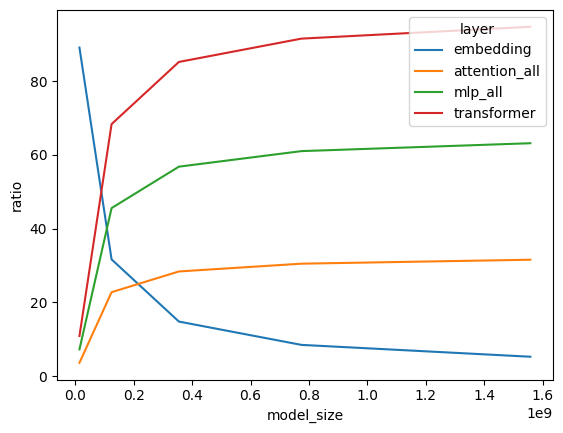

In [5]:
all_model_params = [
    (name, cfg, get_params(cfg))
    for name, cfg in MODEL_CONFIG_ARGS.items()
    # if name != "gpt2-tiny"
]
sorted(all_model_params, key=lambda z: z[2]["total"])

layers_to_plot = ["embedding", "attention_all", "mlp_all", "transformer"]

# Create lists to store the data
data = []
for model_name, model_cfg, model_params in all_model_params:
    params_total = model_params["total"]
    for layer in layers_to_plot:
        layer_params = model_params[layer]
        layer_param_ratio = layer_params / params_total * 100

        data.append(
            {
                "model_size": params_total,
                "model_name": model_name,
                "layer": layer,
                "layer_params": layer_params,
                "ratio": layer_param_ratio,
            }
        )

# Create DataFrame
df = pd.DataFrame(data)

# Example plot
# plt.figure(figsize=(12, 6))
sb.lineplot(data=df, x="model_size", y="ratio", hue="layer")

# Experiments

## GPT2 Batch Size Experiments

Running the batch size benchmarking script on GPT2 models with and without activation checkpointing.

In [6]:
from gollem.utils import get_base_dir_path

# results_dir = get_base_dir_path() / "results" / "gpt2_batch_size_benchmarking"
# no_ac_results_file_path = results_dir / "results_2025-02-09_09-54-36.csv"
# ac_results_file_path = results_dir / "results_2025-02-09_10-12-44_ac.csv"

results_dir = get_base_dir_path() / "results" / "gpt2-xl_batch_size_benchmarking"
no_ac_results_file_path = results_dir / "results_2025-02-20_07-39-13.csv"
ac_results_file_path = results_dir / "results_2025-02-20_07-22-57_ac.csv"

no_ac_df = pd.read_csv(no_ac_results_file_path)
ac_df = pd.read_csv(ac_results_file_path)

no_ac_df.head()
ac_df.head()


def get_batch_size_from_run_name(run_name: str) -> int:
    return int(run_name.split("=")[1].split(" ")[0])


no_ac_df["batch_size"] = no_ac_df["run_name"].apply(get_batch_size_from_run_name)
ac_df["batch_size"] = ac_df["run_name"].apply(get_batch_size_from_run_name)
no_ac_df["ac"] = False
ac_df["ac"] = True

# concat the two dataframes
df = pd.concat([no_ac_df, ac_df])
df.head(15)


,run_name,mini_batch_size,total_batch_size,total_time,mean_iter_time,mean_tps,peak_mem_usage,batch_size,ac
0,batch_size=1024 (1x1024),1024,1024,58.877803,0.074114,13816.467758,24970,1024,False
1,batch_size=2048 (2x1024),2048,2048,78.903281,0.138176,14821.635818,27486,2048,False
2,batch_size=4096 (4x1024),4096,4096,37.082203,0.138722,29526.590909,33523,4096,False
3,batch_size=8192 (8x1024),8192,8192,46.060192,0.225366,36349.738218,45603,8192,False
4,batch_size=16384 (16x1024),16384,16384,65.485047,0.405775,40377.013075,69651,16384,False
0,batch_size=1024 (1x1024),1024,1024,108.784319,0.087713,11674.503401,24982,1024,True
1,batch_size=2048 (2x1024),2048,2048,157.376762,0.108046,18954.956441,24970,2048,True
2,batch_size=4096 (4x1024),4096,4096,41.902336,0.163331,25077.979233,24981,4096,True
3,batch_size=8192 (8x1024),8192,8192,52.431914,0.268575,30501.770893,25063,8192,True
4,batch_size=16384 (16x1024),16384,16384,72.722039,0.488799,33518.869671,28175,16384,True


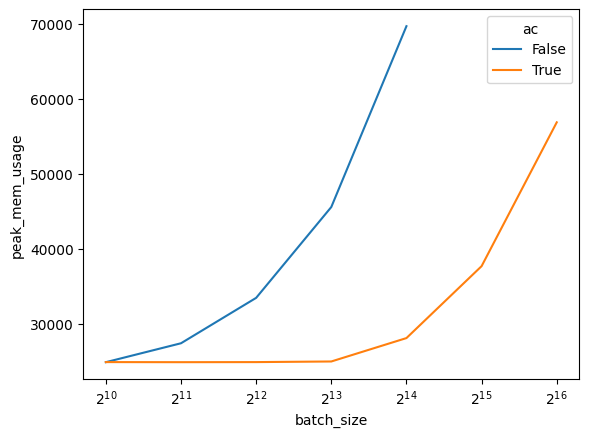

In [7]:
# plot mem usage vs batch size for ac and no ac
# with log 2 scale on x axis
sb.lineplot(data=df, x="batch_size", y="peak_mem_usage", hue="ac")
plt.xscale("log", base=2)
plt.show()


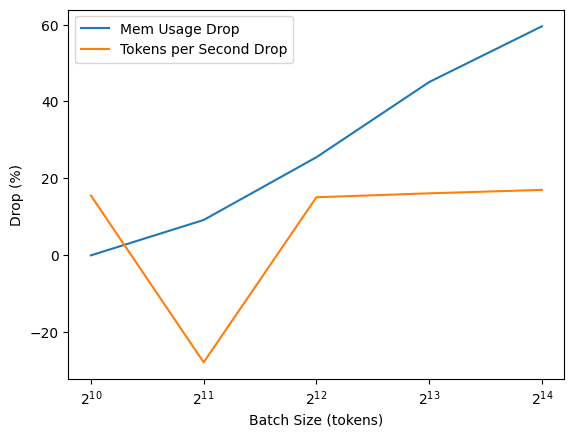

In [8]:
# calculate drop in memory usage for ac over no ac
# make new df with only ac == False
ac_vs_no_ac_df = df.query("ac == False").copy()
# calculate drop in memory usage for ac over no ac
ac_vs_no_ac_df["mem_usage_drop"] = (
    ac_vs_no_ac_df["peak_mem_usage"] - df.query("ac == True")["peak_mem_usage"]
)
ac_vs_no_ac_df["mem_usage_drop_pct"] = (
    ac_vs_no_ac_df["mem_usage_drop"] / ac_vs_no_ac_df["peak_mem_usage"] * 100
)
# calculate drop in tokens per second for ac over no ac
ac_vs_no_ac_df["mean_tps_drop"] = (
    ac_vs_no_ac_df["mean_tps"] - df.query("ac == True")["mean_tps"]
)
ac_vs_no_ac_df["mean_tps_drop_pct"] = (
    ac_vs_no_ac_df["mean_tps_drop"] / ac_vs_no_ac_df["mean_tps"] * 100
)
# plot mem usage drop vs batch size
sb.lineplot(
    data=ac_vs_no_ac_df,
    x="batch_size",
    y="mem_usage_drop_pct",
    label="Mem Usage Drop",
)
sb.lineplot(
    data=ac_vs_no_ac_df,
    x="batch_size",
    y="mean_tps_drop_pct",
    label="Tokens per Second Drop",
)
plt.xlabel("Batch Size (tokens)")
plt.ylabel("Drop (%)")
plt.xscale("log", base=2)
plt.show()

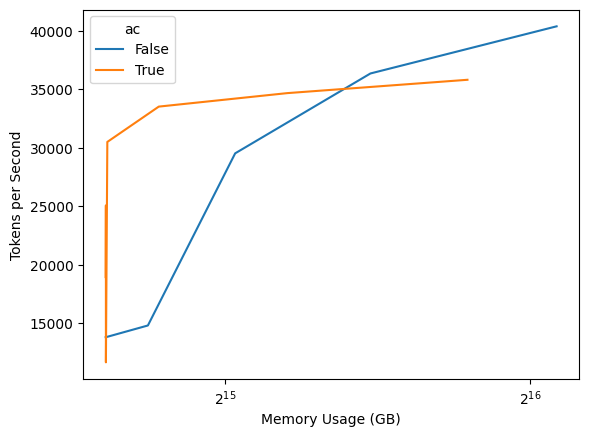

In [9]:
# plot tps vs mem usage for ac and no ac
sb.lineplot(data=df, x="peak_mem_usage", y="mean_tps", hue="ac")
plt.xscale("log", base=2)
plt.xlabel("Memory Usage (GB)")
plt.ylabel("Tokens per Second")
plt.show()
